<a href="https://colab.research.google.com/github/sak-90/FallDetection_MajorProject/blob/main/FallDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving acc_gyr.csv to acc_gyr.csv


In [2]:
import pandas as pd
import numpy as np
import io

df = pd.read_csv(io.BytesIO(uploaded['acc_gyr.csv']))
df.head()

,xAcc,yAcc,zAcc,xGyro,yGyro,zGyro,label
0,6.99,-0.57,-7.28,-2.75,-3.23,2.62,fall
1,6.51,-0.75,-6.93,-0.67,-6.35,4.64,fall
2,6.22,-0.63,-6.73,0.79,-5.49,3.85,fall
3,6.34,-0.62,-6.80,1.59,-2.26,0.67,fall
4,6.49,-0.39,-6.60,0.67,-0.24,-1.10,fall


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96800 entries, 0 to 96799
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   xAcc    96800 non-null  float64
 1   yAcc    96800 non-null  float64
 2   zAcc    96800 non-null  float64
 3   xGyro   96800 non-null  float64
 4   yGyro   96800 non-null  float64
 5   zGyro   96800 non-null  float64
 6   label   96800 non-null  object 
dtypes: float64(6), object(1)
memory usage: 5.2+ MB


In [4]:
from scipy.stats import skew
from scipy.stats import kurtosis

df['accSkewness'] = df[['xAcc', 'yAcc', 'zAcc']].apply(skew, axis=1)
df['gyroSkewness'] = df[['xAcc', 'yAcc', 'zAcc']].apply(skew, axis=1)
df['accKurtosis'] = df[['xAcc', 'yAcc', 'zAcc']].apply(kurtosis, axis=1)
df['gyroKurtosis'] = df[['xAcc', 'yAcc', 'zAcc']].apply(kurtosis, axis=1)

df.head()

,xAcc,yAcc,zAcc,xGyro,yGyro,zGyro,label,accSkewness,gyroSkewness,accKurtosis,gyroKurtosis
0,6.99,-0.57,-7.28,-2.75,-3.23,2.62,fall,0.072795,0.072795,-1.5,-1.5
1,6.51,-0.75,-6.93,-0.67,-6.35,4.64,fall,0.098030,0.098030,-1.5,-1.5
2,6.22,-0.63,-6.73,0.79,-5.49,3.85,fall,0.070786,0.070786,-1.5,-1.5
3,6.34,-0.62,-6.80,1.59,-2.26,0.67,fall,0.072545,0.072545,-1.5,-1.5
4,6.49,-0.39,-6.60,0.67,-0.24,-1.10,fall,0.062587,0.062587,-1.5,-1.5


In [7]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE


def preprocess_dataset(data, seed=69420):
    new_data = data.drop("label",axis=1).to_numpy().reshape(-1, 400, 10)
    labels = np.array(data.label.iloc[np.arange(0,data.shape[0], 400)])

    sm = SMOTE(random_state=seed)
    y = labels
    X, y = sm.fit_resample(new_data.reshape(-1, 400*10), y)

    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, 400*2))
    X_test = scaler.fit_transform(X_test.reshape(-1, 400*10))

    # reshape
    X_train = X_train.reshape(-1, 400, 10)
    X_test = X_test.reshape(-1, 400, 10)
    input_shape = X_train.shape[1:]
    seq_len, n_features = input_shape

    le = LabelEncoder()
    le.fit(np.unique(y_train))
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=13)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=13)

    X_train = X_train.reshape(-1, seq_len, n_features)
    X_test = X_test.reshape(-1, seq_len, n_features)

    return X_train, X_test, y_train, y_test, input_shape

In [8]:
X_train, X_test, y_train, y_test, input_shape = preprocess_dataset(df)

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
import itertools

def create_confusion_matrix(model):
  y_pred = model.predict(X_test)
  y_pred_classes = np.argmax(y_pred, axis=1)
  y_true_classes = np.argmax(y_test, axis=1)

  conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

  class_names = [str(i) for i in range(conf_matrix.shape[0])]

  def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
      """
      This function prints and plots the confusion matrix.
      Normalization can be applied by setting `normalize=True`.
      """
      if normalize:
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
          print("Normalized confusion matrix")
      else:
          print('Confusion matrix, without normalization')

      print(cm)

      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title)
      plt.colorbar()
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation=45)
      plt.yticks(tick_marks, classes)

      fmt = '.2f' if normalize else 'd'
      thresh = cm.max() / 2.
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")

      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.tight_layout()

  # Plot non-normalized confusion matrix
  plt.figure(figsize=(8, 8))
  plot_confusion_matrix(conf_matrix, classes=class_names, title='Confusion Matrix - Non-Normalized')

  # Plot normalized confusion matrix
  plt.figure(figsize=(8, 8))
  plot_confusion_matrix(conf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')

  plt.show()

## Training model: CNN

In [52]:
from tensorflow.keras import layers, models, optimizers

first_model = models.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(13, activation='sigmoid')
])

first_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [53]:
history = first_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
12/12 [==============================] - 2s 67ms/step - loss: 0.1923 - accuracy: 0.5912 - val_loss: 0.0570 - val_accuracy: 0.9091
Epoch 2/50
12/12 [==============================] - 0s 26ms/step - loss: 0.0351 - accuracy: 0.9448 - val_loss: 0.0463 - val_accuracy: 0.9174
Epoch 3/50
12/12 [==============================] - 0s 28ms/step - loss: 0.0159 - accuracy: 0.9862 - val_loss: 0.0230 - val_accuracy: 0.9917
Epoch 4/50
12/12 [==============================] - 0s 29ms/step - loss: 0.0065 - accuracy: 0.9945 - val_loss: 0.0236 - val_accuracy: 0.9752
Epoch 5/50
12/12 [==============================] - 0s 24ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0193 - val_accuracy: 0.9917
Epoch 6/50
12/12 [==============================] - 0s 29ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0172 - val_accuracy: 0.9917
Epoch 7/50
12/12 [==============================] - 0s 25ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0171 - val_accuracy: 0.9917
Epoch 8/50
12

In [54]:
print("validation_loss", history.history['val_loss'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

validation_loss 0.017145436257123947
validation_accuracy 0.9752066135406494


In [56]:
prediction = first_model.evaluate(X_test, y_test)
print("prediction_accuracy", prediction[1]*100, "%")

4/4 [==============================] - 0s 14ms/step - loss: 0.0171 - accuracy: 0.9752
prediction_accuracy 97.52066135406494 %


<Axes: >

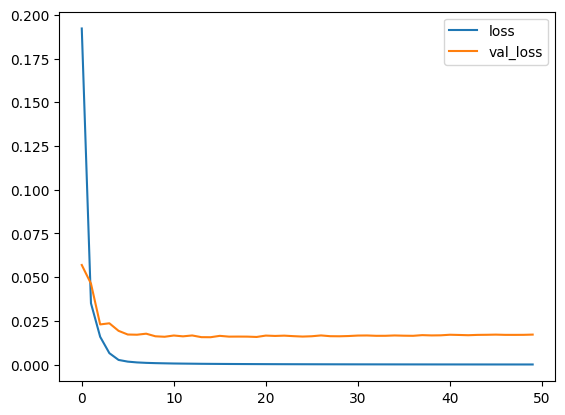

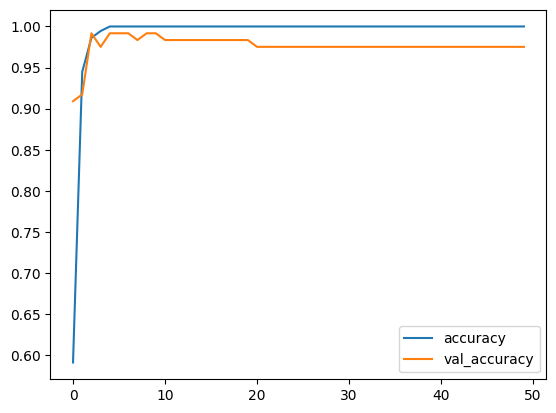

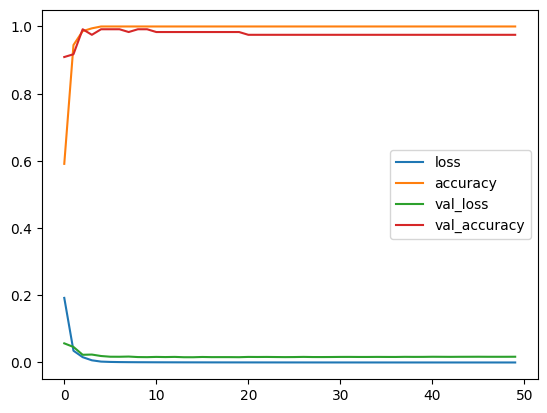

In [57]:
losses = pd.DataFrame(history.history)
losses.head()
losses[['loss','val_loss']].plot()
losses[['accuracy','val_accuracy']].plot()
losses.plot()

4/4 [==============================] - 0s 6ms/step
Confusion matrix, without normalization
[[15  1  0  0  0  0  0]
 [ 0 17  0  0  0  0  0]
 [ 0  0 21  0  0  0  2]
 [ 0  0  0 13  0  0  0]
 [ 0  0  0  0 18  0  0]
 [ 0  0  0  0  0 16  0]
 [ 0  0  0  0  0  0 18]]
Normalized confusion matrix
[[0.9375     0.0625     0.         0.         0.         0.
  0.        ]
 [0.         1.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.91304348 0.         0.         0.
  0.08695652]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.         1.         0.
  0.        ]
 [0.         0.         0.         0.         0.         1.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


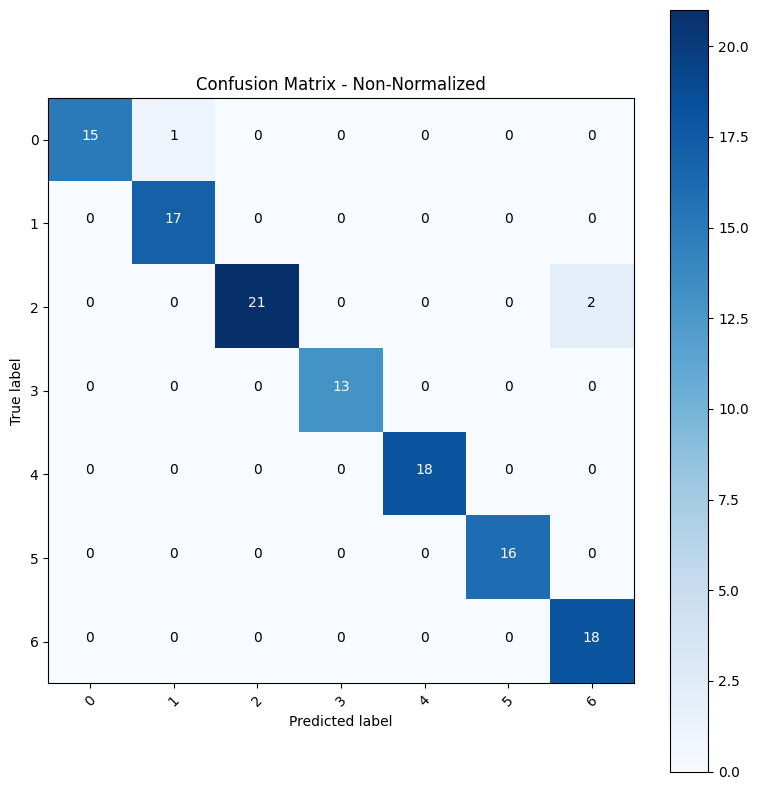

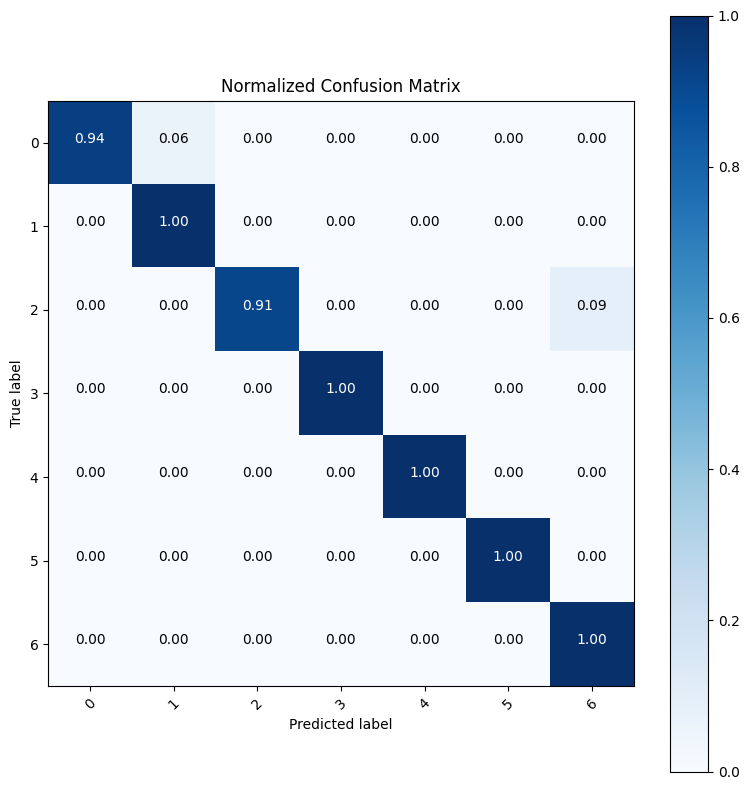

In [74]:
create_confusion_matrix(first_model)

## VGG16-like CNN

In [58]:
second_model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
    layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(13, activation='sigmoid')
])

second_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [59]:
history = second_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
12/12 [==============================] - 8s 430ms/step - loss: 0.3157 - accuracy: 0.3011 - val_loss: 0.2047 - val_accuracy: 0.2975
Epoch 2/30
12/12 [==============================] - 7s 578ms/step - loss: 0.1416 - accuracy: 0.5801 - val_loss: 0.1389 - val_accuracy: 0.6777
Epoch 3/30
12/12 [==============================] - 6s 512ms/step - loss: 0.0913 - accuracy: 0.7873 - val_loss: 0.1157 - val_accuracy: 0.7521
Epoch 4/30
12/12 [==============================] - 6s 512ms/step - loss: 0.0572 - accuracy: 0.8702 - val_loss: 0.0828 - val_accuracy: 0.8430
Epoch 5/30
12/12 [==============================] - 5s 433ms/step - loss: 0.0372 - accuracy: 0.9199 - val_loss: 0.1283 - val_accuracy: 0.7686
Epoch 6/30
12/12 [==============================] - 5s 445ms/step - loss: 0.0277 - accuracy: 0.9420 - val_loss: 0.1017 - val_accuracy: 0.7521
Epoch 7/30
12/12 [==============================] - 7s 581ms/step - loss: 0.0451 - accuracy: 0.9116 - val_loss: 0.1014 - val_accuracy: 0.8264
Epoch 

In [60]:
print("validation_loss", history.history['val_loss'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

validation_loss 0.11177891492843628
validation_accuracy 0.93388432264328


In [61]:
prediction = second_model.evaluate(X_test, y_test)
print("prediction_accuracy", prediction[1]*100, "%")

4/4 [==============================] - 0s 94ms/step - loss: 0.1118 - accuracy: 0.9339
prediction_accuracy 93.388432264328 %


<Axes: >

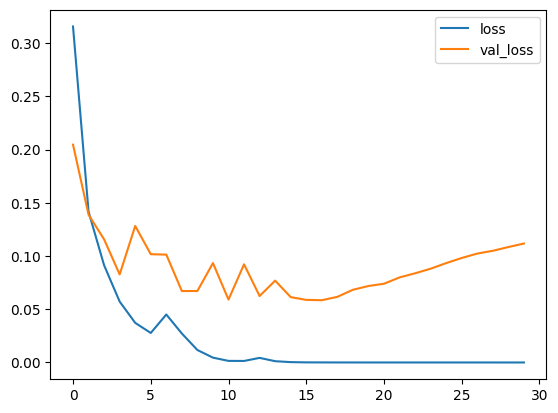

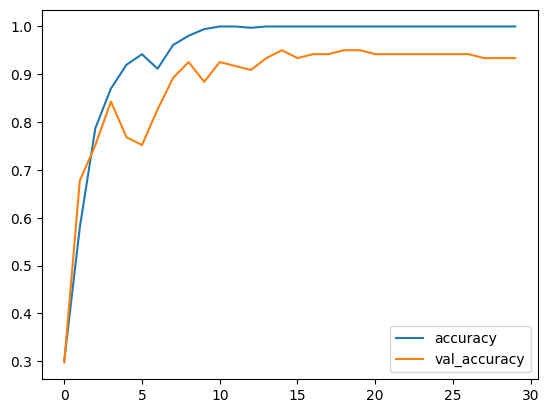

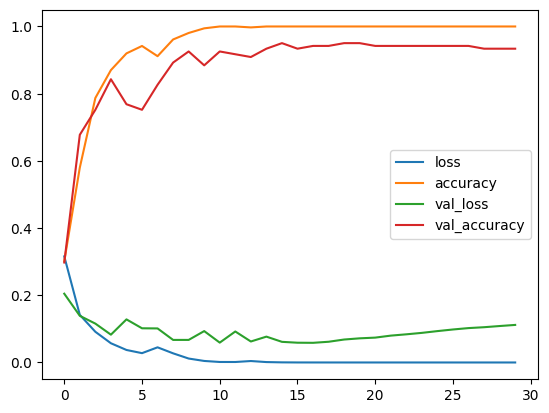

In [62]:
losses = pd.DataFrame(history.history)
losses.head()
losses[['loss','val_loss']].plot()
losses[['accuracy','val_accuracy']].plot()
losses.plot()

4/4 [==============================] - 1s 146ms/step
Confusion matrix, without normalization
[[12  1  0  2  0  0  1]
 [ 0 17  0  0  0  0  0]
 [ 0  0 19  0  0  0  4]
 [ 0  0  0 13  0  0  0]
 [ 0  0  0  0 18  0  0]
 [ 0  0  0  0  0 16  0]
 [ 0  0  0  0  0  0 18]]
Normalized confusion matrix
[[0.75       0.0625     0.         0.125      0.         0.
  0.0625    ]
 [0.         1.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.82608696 0.         0.         0.
  0.17391304]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.         1.         0.
  0.        ]
 [0.         0.         0.         0.         0.         1.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


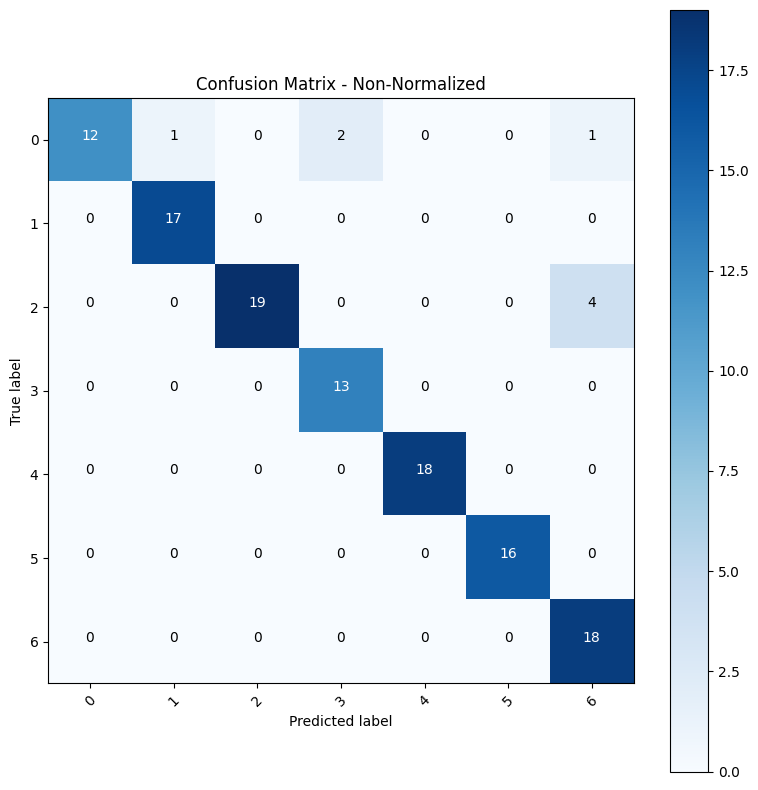

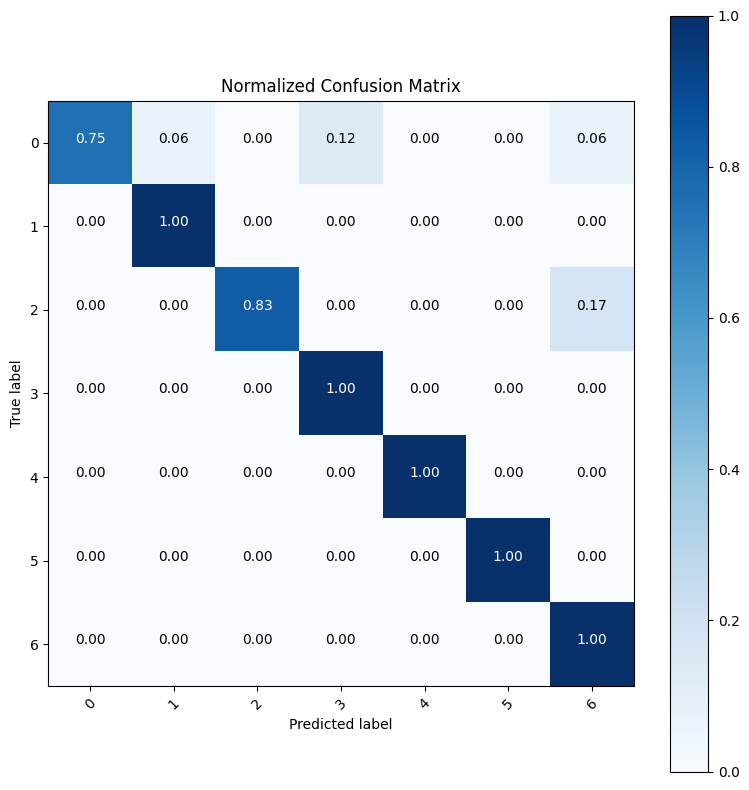

In [75]:
create_confusion_matrix(second_model)

### NN with LSTM layer

In [63]:
third_model = models.Sequential([
    layers.Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(13, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.01)
third_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [64]:
history = third_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
12/12 [==============================] - 10s 444ms/step - loss: 4.3406 - accuracy: 0.5055 - val_loss: 2.8663 - val_accuracy: 0.5207
Epoch 2/50
12/12 [==============================] - 3s 220ms/step - loss: 0.9522 - accuracy: 0.7486 - val_loss: 0.3150 - val_accuracy: 0.9174
Epoch 3/50
12/12 [==============================] - 3s 225ms/step - loss: 0.2027 - accuracy: 0.9365 - val_loss: 0.3056 - val_accuracy: 0.9256
Epoch 4/50
12/12 [==============================] - 3s 225ms/step - loss: 0.0734 - accuracy: 0.9779 - val_loss: 0.2224 - val_accuracy: 0.9587
Epoch 5/50
12/12 [==============================] - 4s 328ms/step - loss: 0.0461 - accuracy: 0.9807 - val_loss: 0.3350 - val_accuracy: 0.9091
Epoch 6/50
12/12 [==============================] - 3s 271ms/step - loss: 0.0120 - accuracy: 0.9972 - val_loss: 0.2000 - val_accuracy: 0.9587
Epoch 7/50
12/12 [==============================] - 3s 234ms/step - loss: 0.0086 - accuracy: 0.9972 - val_loss: 0.1992 - val_accuracy: 0.9669
Epoch

In [65]:
print("validation_loss", history.history['val_loss'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

validation_loss 0.19489848613739014
validation_accuracy 0.9586777091026306


In [66]:
prediction = third_model.evaluate(X_test, y_test)
print("prediction_accuracy", prediction[1]*100, "%")

4/4 [==============================] - 0s 91ms/step - loss: 0.1949 - accuracy: 0.9587
prediction_accuracy 95.86777091026306 %


<Axes: >

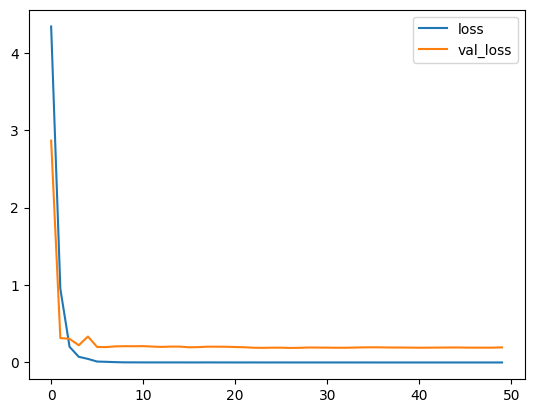

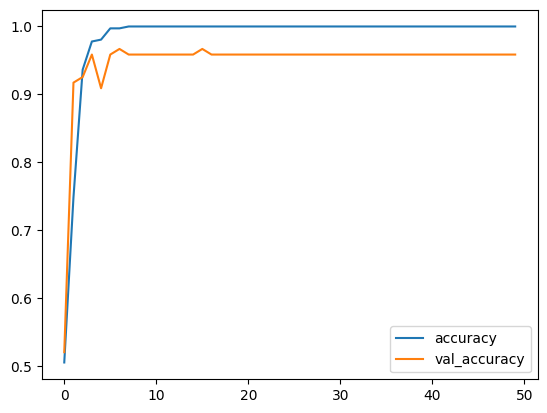

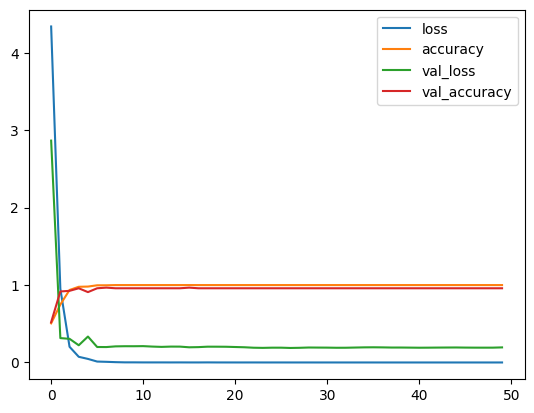

In [67]:
losses = pd.DataFrame(history.history)
losses.head()
losses[['loss','val_loss']].plot()
losses[['accuracy','val_accuracy']].plot()
losses.plot()

4/4 [==============================] - 1s 208ms/step
Confusion matrix, without normalization
[[15  1  0  0  0  0  0]
 [ 0 17  0  0  0  0  0]
 [ 0  0 20  0  1  2  0]
 [ 0  0  0 13  0  0  0]
 [ 0  0  0  0 18  0  0]
 [ 0  0  0  0  0 16  0]
 [ 0  0  0  0  0  1 17]]
Normalized confusion matrix
[[0.9375     0.0625     0.         0.         0.         0.
  0.        ]
 [0.         1.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.86956522 0.         0.04347826 0.08695652
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.         1.         0.
  0.        ]
 [0.         0.         0.         0.         0.         1.
  0.        ]
 [0.         0.         0.         0.         0.         0.05555556
  0.94444444]]


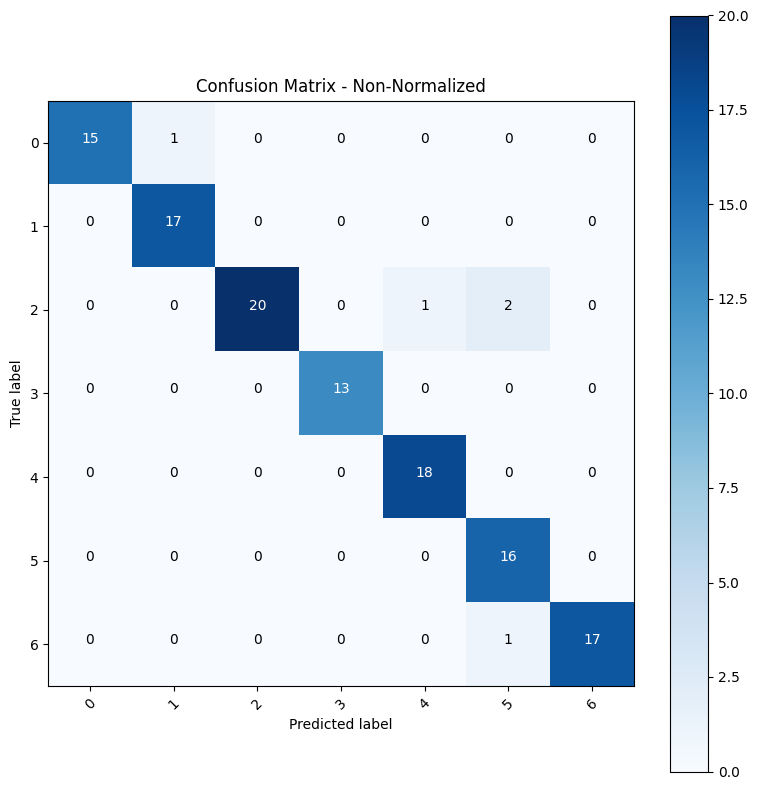

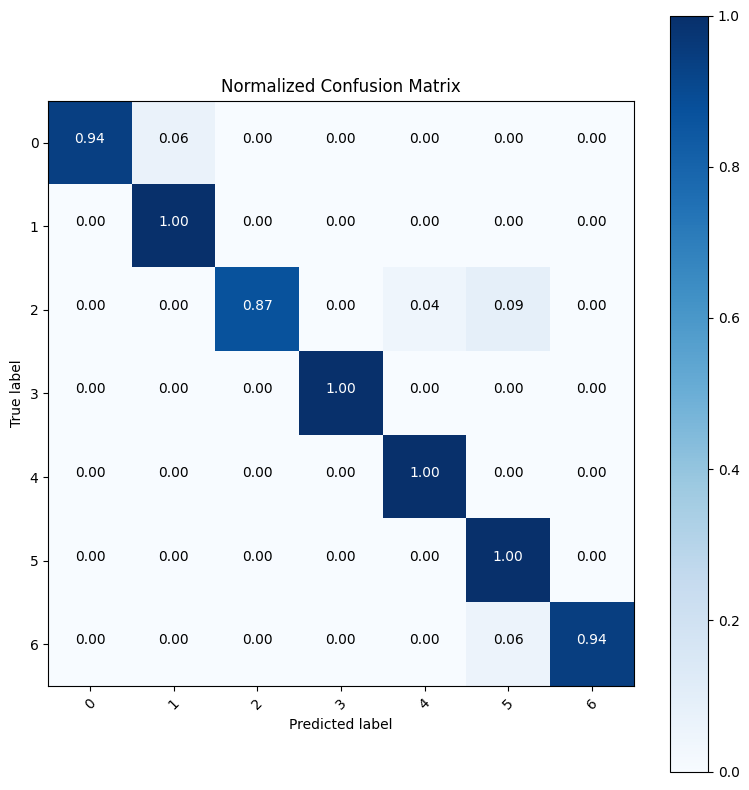

In [76]:
create_confusion_matrix(third_model)